**Link to dataset:** https://drive.google.com/file/d/1q8SYcjOJULdSkETv5S_gd7xNq1GrBHAO/view

## **Libraries Used**

In [0]:
# to install these packages if they aren't there already, use below install commands:
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install scipy
# !pip install imblearn
import pandas as pd
import numpy as np
import random
import sklearn
from collections import Counter

In [0]:
sklearn.__version__

'0.22.2.post1'

**DISCLAIMER: Uploading the fraud_data.csv file takes a lot of time. It might crash your machine**

In [0]:
# Only for Google Colab users
from google.colab import files
uploaded = files.upload()

Saving fraud_data.csv to fraud_data.csv


In [0]:
df = pd.read_csv("fraud_data.csv")

In [0]:
df.isFraud.value_counts()

0    57049
1     2005
Name: isFraud, dtype: int64

In [0]:
df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2994681,0,242834,25.000,H,9803,583.0,150.0,visa,226.0,credit,269.0,87.0,NaN,NaN,yahoo.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.791666,0.791666,...,0.0,82050.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,NaN,529.0,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10.12,firefox 56.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,rv:56.0
1,3557242,0,15123000,117.000,W,7919,194.0,150.0,mastercard,166.0,debit,181.0,87.0,483.0,NaN,gmail.com,NaN,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,35.0,1.0,4.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3327470,0,8378575,73.773,C,12778,500.0,185.0,mastercard,224.0,credit,284.0,60.0,NaN,NaN,hotmail.com,hotmail.com,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,54.0,35.0,54.0,35.0,54.0,35.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3118781,0,2607840,400.000,R,12316,548.0,150.0,visa,195.0,credit,441.0,87.0,NaN,371.0,anonymous.com,anonymous.com,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,183599.0,NaN,NaN,6.0,-11.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,15.0,352.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 10.3.3,mobile safari generic,32.0,1136x640,match_status:2,T,F,T,F,mobile,iOS Device
4,3459772,0,12226544,31.950,W,9002,453.0,150.0,visa,226.0,debit,264.0,87.0,10.0,NaN,yahoo.com,NaN,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,54.0,15.0,405.0,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59049,3549150,0,14898396,335.000,W,2616,327.0,150.0,discover,102.0,credit,325.0,87.0,NaN,NaN,hotmail.com,NaN,3,1,0,0,0,1,0,0,2,0,1,0,3,3,0.0,NaN,NaN,236.0,159.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59050,3497600,0,13371647,20.950,W,3277,111.0,150.0,visa,226.0,debit,231.0,87.0,17.0,NaN,NaN,NaN,118,96,0,0,83,79,0,0,72,0,82,0,473,91,17.0,17.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59051,3575755,0,15775109,59.000,W,9486,127.0,150.0,mastercard,224.0,debit,327.0,87.0,13.0,NaN,gmail.com,NaN,1,1,0,0,0,1,0,0,1,0,1,0,2,1,27.0,27.0,27.0,27.0,27.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59052,3521246,0,14071016,25.950,W,2392,360.0,150.0,mastercard,126.0,debit,469.0,87.0,NaN,NaN,gmail.com,NaN,4,6,0,0,1,4,0,0,4,0,5,0,9,4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Pre-Processing and Data Wrangling:

## Train Test Data Split - to evaluate performance in an unbiased manner

In [0]:
# set x and y variables
y = df['isFraud']
x= df.loc[:, df.columns != 'isFraud']


from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 123)


In [0]:
xTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41337 entries, 12662 to 52734
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(385), int64(17), object(31)
memory usage: 136.9+ MB


## Step 1. Check for missingness in variables 

In [0]:
xTrain.isnull().sum()

TransactionID         0
TransactionDT         0
TransactionAmt        0
ProductCD             0
card1                 0
                  ...  
id_36             31403
id_37             31403
id_38             31403
DeviceType        31419
DeviceInfo        33011
Length: 433, dtype: int64

## Eliminate automatically variables with more than 20% of missingness

In [0]:
# Eliminate automatically variables with more than 20% of missingness

xTrain = xTrain[xTrain.columns[xTrain.isnull().mean() < 0.2]]

In [0]:
missing_cols=xTrain.columns[xTrain.isnull().mean() > 0]
print(missing_cols)

Index(['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'D1', 'D10',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=162)


In [0]:
xTrain['card5'].isnull().mean()

0.007499334736434671

## Imputation : Filling missing values in a variable by reasonable approximations like mean of the variable to allow machine learning models to work

## Step 1a. Single Imputation Technique

## Impute Numeric Variables with mean of the variable

In [0]:
xTrain_single= xTrain
cols= xTrain_single.columns
num_cols = xTrain_single.select_dtypes(include=np.number).columns
xTrain_single[num_cols] = xTrain_single[num_cols].fillna(xTrain[num_cols].mean())
print(num_cols)
print(xTrain_single[num_cols].mean())

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card5', 'addr1', 'addr2', 'C1',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=177)
TransactionID     3.281805e+06
TransactionDT     7.357705e+06
TransactionAmt    1.347207e+02
card1             9.912457e+03
card2             3.626188e+02
                      ...     
V317              2.722976e+02
V318              1.823263e+02
V319              1.665254e+01
V320              4.211091e+01
V321              2.752951e+01
Length: 177, dtype: float64


## Impute Categorical Variables with mode of the variable

In [0]:
cat_cols= list(set(cols) - set(num_cols))
xTrain_single[cat_cols] = xTrain_single[cat_cols].fillna(xTrain[cat_cols].mode().iloc[0])
train_cols = xTrain_single.columns
print(cat_cols)
print(xTrain_single[cat_cols].mode().iloc[0])

['P_emaildomain', 'ProductCD', 'card4', 'card6']
P_emaildomain    gmail.com
ProductCD                W
card4                 visa
card6                debit
Name: 0, dtype: object


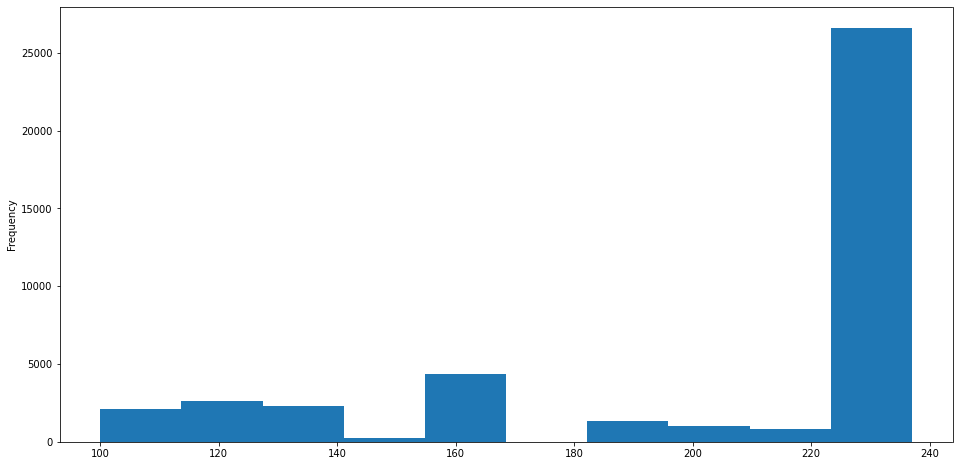

In [0]:
xTrain_single['card5'].plot.hist(figsize=(16,8));

## They look almost same, but distribution of these variables (mean, standard deviation etc) also didn't change which way we imputed missing values, as you can see below 

In [0]:
xTrain_single['card5'].describe()

count    41337.000000
mean       199.235991
std         41.036349
min        100.000000
25%        166.000000
50%        226.000000
75%        226.000000
max        237.000000
Name: card5, dtype: float64

The mean, std etc remain the same for the variable whether we imputed by single imputation technique or multiple imputation technique.

### Hence giving an insight that in the bigger picture, it is okay to impute with single imputation technqiue, keeping it simple.. 

In [0]:
xTrain= xTrain_single

## Step 2. One hot encoding : To make all variables numeric to feed to machine learning process further

In [0]:
xTrain.info()
xTrain_dummy = pd.get_dummies(xTrain, prefix_sep='_', drop_first=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41337 entries, 12662 to 52734
Columns: 181 entries, TransactionID to V321
dtypes: float64(160), int64(17), object(4)
memory usage: 57.4+ MB


In [0]:
xTrain_dummy

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,...,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
12662,3058646,1612658,46.500,7861,494.0,150.0,226.0,299.000000,87.000000,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47037,3469434,12533197,20.950,10748,455.0,150.0,195.0,337.000000,87.000000,9,10,0,0,6,9,0,0,6,0,10,0,49,8,136.0,82.000000,135.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29179,3302515,7855766,139.117,4606,141.0,185.0,137.0,290.763705,86.802851,1,1,0,1,0,1,1,0,0,0,1,1,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40680,3010196,595984,280.330,4141,404.0,150.0,102.0,327.000000,87.000000,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6080,3288879,7447462,186.610,13266,321.0,150.0,226.0,158.000000,87.000000,13,11,0,0,7,5,0,0,7,0,7,0,24,9,1.0,40.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54370,3500688,13452492,311.950,10057,225.0,150.0,224.0,123.000000,87.000000,3,3,0,0,1,0,0,0,2,0,1,0,12,3,121.0,276.000000,276.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17730,3038837,1212291,114.950,2492,543.0,150.0,224.0,299.000000,87.000000,3,3,0,0,3,2,0,0,1,0,2,0,13,3,77.0,76.000000,76.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28030,3055357,1544901,75.000,1690,516.0,150.0,224.0,110.000000,87.000000,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,124.

## Step 3. Scaling/Normalizing Data

The preprocessing module further provides a utility class StandardScaler that implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.

In [0]:
from sklearn import preprocessing
scaled_tr = preprocessing.StandardScaler().fit_transform(xTrain_dummy)
final_tr = pd.DataFrame(data=scaled_tr)
final_tr.columns= xTrain_dummy.columns
final_tr
print(final_tr.head())
print(final_tr.shape)

   TransactionID  ...  P_emaildomain_ymail.com
0      -1.312209  ...                -0.064261
1       1.103287  ...                -0.064261
2       0.121778  ...                -0.064261
3      -1.597102  ...                -0.064261
4       0.041596  ...                -0.064261

[5 rows x 245 columns]
(41337, 245)


In [0]:
from sklearn import preprocessing
#scaled_tr = preprocessing.StandardScaler().fit_transform(xTrain_dummy)
final_tr = pd.DataFrame(data=xTrain_dummy)
final_tr.columns= xTrain_dummy.columns
final_tr
print(final_tr.head())
print(final_tr.shape)

       TransactionID  ...  P_emaildomain_ymail.com
12662        3058646  ...                        0
47037        3469434  ...                        0
29179        3302515  ...                        0
40680        3010196  ...                        0
6080         3288879  ...                        0

[5 rows x 245 columns]
(41337, 245)


In [0]:
## Decision Tree using grid search CV
from sklearn import tree
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=final_tr, y=yTrain)
dt = clf.best_estimator_  #final decision tree!
print (clf.best_score_, clf.best_params_) 

0.7640108272758495 {'max_depth': 8}


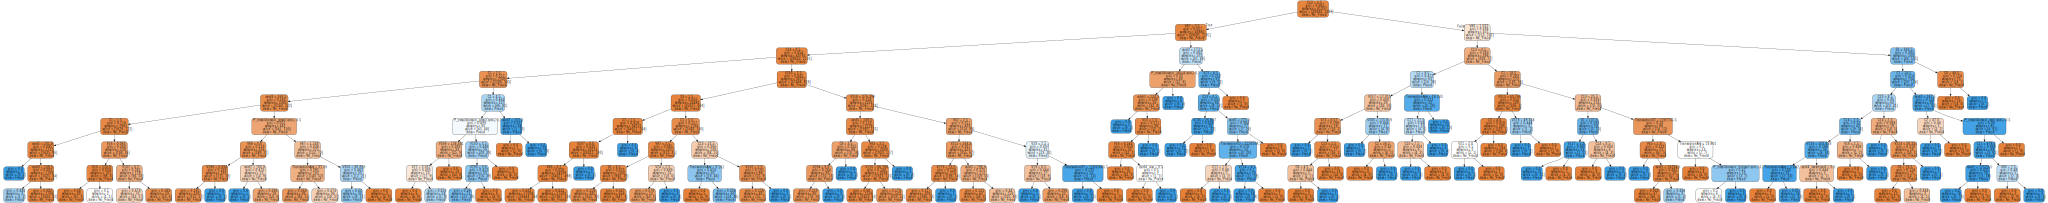

In [0]:
## Visualizing the decision tree- load visualization libraries
from sklearn.tree import export_graphviz
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, 
                    feature_names=final_tr.columns,  
                      class_names=['No_Fraud','Fraud'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph


## Part 2: Handling Class Imbalance
###  Repeat the above with handled Class Imbalance
### *** Let us use data from step 2 (one hot encoded), use SMOTE and resample data and scale data (step 3)) ***

We can update the example to first oversample the minority class to have 20 percent the number of examples of the majority class (here about 8k), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 15k).

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.2,random_state=2)
#under = RandomUnderSampler(sampling_strategy=0.2)
#,('u', under)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(xTrain_dummy, yTrain)


print('Original dataset shape %s' % Counter(yTrain))
print('Resampled dataset shape %s' % Counter(y_res))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 39944, 1: 1393})
Resampled dataset shape Counter({0: 39944, 1: 7988})


### As you see in the above output, the dataset originally had just 1393 fraud cases and arodun 40k non fraud transactions.
### Now thanks to oversampling via SMOTE and undersampling, we have  number of fraud and non-fraud cases in the ratio 2:1 and are relatively balanced information for model to learn

##  Step 3  Scaling Data for SMOTE'd (Resampled) Data

The preprocessing module further provides a utility class StandardScaler that implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.

In [0]:
from sklearn import preprocessing
scaled_tr_res = preprocessing.StandardScaler().fit_transform(X_res)
final_tr_res = pd.DataFrame(data=scaled_tr_res)
final_tr_res.columns= xTrain_dummy.columns
final_tr_res
print(final_tr_res.head())

   TransactionID  ...  P_emaildomain_ymail.com
0      -1.327440  ...                -0.060872
1       1.104636  ...                -0.060872
2       0.116390  ...                -0.060872
3      -1.614289  ...                -0.060872
4       0.035658  ...                -0.060872

[5 rows x 245 columns]


In [0]:
from sklearn import preprocessing
#scaled_tr_res = preprocessing.StandardScaler().fit_transform(X_res)
final_tr_res = pd.DataFrame(data=X_res)
final_tr_res.columns= xTrain_dummy.columns
final_tr_res
print(final_tr_res.head())

   TransactionID  ...  P_emaildomain_ymail.com
0      3058646.0  ...                      0.0
1      3469434.0  ...                      0.0
2      3302515.0  ...                      0.0
3      3010196.0  ...                      0.0
4      3288879.0  ...                      0.0

[5 rows x 245 columns]


In [0]:
## Decision Tree using grid search CV
from sklearn import tree
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=final_tr_res, y=y_res)
dt_smote = clf.best_estimator_  #final decision tree!
print (clf.best_score_, clf.best_params_) 

0.9258614171701941 {'max_depth': 7}


## As you see, there is an increased performance on resampled data after handling class imbalance. But let us now judge early! Let us judge by the performance on the unseen test data which we separated earlier

## Apply on Test Data : apply steps 1-3 namely 
1. Apply single imputation, 
2. One Hot encode variables
3. Scale Data

### Step 1: Account for missing values with single imputation like we did earlier

In [0]:

cols= xTest.columns
num_cols = xTest.select_dtypes(include=np.number).columns
xTest[num_cols] = xTest[num_cols].fillna(xTest[num_cols].mean())

cat_cols= list(set(cols) - set(num_cols))
xTest[cat_cols] = xTest[cat_cols].fillna(xTest[cat_cols].mode().iloc[0])
test_cols = xTest.columns


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Step extra:  Select only those features which are there in training #

In [0]:

#train_cols = xTrain.columns
xTest = xTest[train_cols] 

### Step 2. One Hot encode variables

In [0]:
xTest.info()
xTest_dummy = pd.get_dummies(xTest, prefix_sep='_', drop_first=True)
# Dummify categorical vars
xTest_dummy = pd.get_dummies(xTest, prefix_sep='__', drop_first=True)

##missing columns levels train and test
missing_levels_cols= list(set(xTrain_dummy.columns) - set(xTest_dummy.columns))


for c in missing_levels_cols:
    xTest_dummy[c]=0

# Select only those columns which are there in training data
xTest_dummy=xTest_dummy[xTrain_dummy.columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17717 entries, 59044 to 426
Columns: 181 entries, TransactionID to V321
dtypes: float64(160), int64(17), object(4)
memory usage: 24.6+ MB


## 3. Scale test Data just like the Training Data

In [0]:
from sklearn import preprocessing
scaled_ts=preprocessing.StandardScaler().fit_transform(xTest_dummy)
final_ts = pd.DataFrame(data=scaled_ts)
final_ts.columns= xTest_dummy.columns
final_ts
print(final_ts.head())
print(final_ts.shape)

   TransactionID  ...  P_emaildomain_ymail.com
0      -0.514765  ...                      0.0
1      -0.593868  ...                      0.0
2      -0.214865  ...                      0.0
3      -1.567012  ...                      0.0
4       0.412205  ...                      0.0

[5 rows x 245 columns]
(17717, 245)


In [0]:
from sklearn import preprocessing
#scaled_ts=preprocessing.StandardScaler().fit_transform(xTest_dummy)
final_ts = pd.DataFrame(data=xTest_dummy)
final_ts.columns= xTest_dummy.columns
final_ts
print(final_ts.head())
print(final_ts.shape)

       TransactionID  ...  P_emaildomain_ymail.com
59044        3195138  ...                        0
29992        3181635  ...                        0
56452        3246331  ...                        0
7059         3015519  ...                        0
49961        3353372  ...                        0

[5 rows x 245 columns]
(17717, 245)


In [0]:
ytest_dt = dt.predict_proba(final_ts)



In [0]:
from sklearn.metrics import roc_curve,roc_auc_score
roc_auc_score(yTest,ytest_dt[:,1])
#roc_curve(yTest,ytest_dt[:,1])

0.7711385655304701

In [0]:
ytest_dt_smote = dt_smote.predict_proba(final_ts)
roc_auc_score(yTest,ytest_dt_smote[:,1])

0.8196808256577502

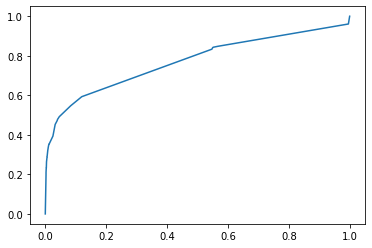

In [0]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(yTest,ytest_dt[:,1], pos_label=1)
plt.plot(fpr, tpr)